In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# Sparse Recurrent Connections
# --------------------------
class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, prob_connection, units):
        """
        Constructs a fixed binary mask for recurrent weights.
        Args:
            prob_connection (float): Desired connection probability.
            units (int): Number of GRU units.
        """
        self.prob_connection = prob_connection
        self.units = units

        # Create a base mask of shape (units, units)
        base_mask = np.random.rand(units, units) < prob_connection
        self.base_mask = tf.constant(base_mask.astype(np.float32))
    
    def __call__(self, w):
        # w is expected to have shape (units, m) where m is a multiple of units.
        m = w.shape[1]
        factor = m // self.units
        # Tiled mask of shape (units, units x factor)
        mask_tiled = tf.tile(self.base_mask, [1, factor])
        return w * mask_tiled
    
    def get_config(self):
        return {'prob_connection': self.prob_connection, 'units': self.units}

# --------------------------
# Modified GRU unit
# --------------------------
class ModifiedGRUCell(tf.keras.layers.Layer):
    def __init__(self, units, alpha=0.1, **kwargs):
        """
        A modified GRU cell that implements leaky, threshold-linear dynamics with dynamic time constants.
        Args:
            units (int): Number of units.
            alpha (float): A factor representing the discretized time step over the time constant.
        """
        super(ModifiedGRUCell, self).__init__(**kwargs)
        self.units = units
        self.alpha = alpha
        self.state_size = units
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Weights for the direct input and recurrent candidate term
        self.W_in = self.add_weight(shape=(input_dim, self.units),
                                    initializer='glorot_uniform',
                                    name='W_in')
        self.W_rec = self.add_weight(shape=(self.units, self.units),
                                     initializer='orthogonal',
                                     name='W_rec')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='b')
        
        # Weights for the gate l
        self.Wl_in = self.add_weight(shape=(input_dim, self.units),
                                     initializer='glorot_uniform',
                                     name='Wl_in')
        self.Wl_rec = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='Wl_rec')
        self.bl = self.add_weight(shape=(self.units,),
                                  initializer='zeros',
                                  name='bl')
        
        # Weights for the gate g
        self.Wg_in = self.add_weight(shape=(input_dim, self.units),
                                     initializer='glorot_uniform',
                                     name='Wg_in')
        self.Wg_rec = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='Wg_rec')
        self.bg = self.add_weight(shape=(self.units,),
                                  initializer='zeros',
                                  name='bg')
        super(ModifiedGRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]

        # Compute the leak gate l that modulates the effective time constant
        l = tf.sigmoid(tf.matmul(h_prev, self.Wl_rec) + tf.matmul(inputs, self.Wl_in) + self.bl)

        # Compute the gate g that modulates the recurrent input
        g = tf.sigmoid(tf.matmul(h_prev, self.Wg_rec) + tf.matmul(inputs, self.Wg_in) + self.bg)

        # Compute the candidate update
        candidate = tf.matmul(g * h_prev, self.W_rec) + tf.matmul(inputs, self.W_in) + self.b

        # Update the state
        h_new = h_prev + self.alpha * l * (-h_prev + candidate)

        # Apply threshold-linear activation
        h_new = tf.maximum(0.0, h_new)

        return h_new, [h_new]

class ModifiedGRU(tf.keras.layers.Layer):
    def __init__(self, units, return_sequences=False, return_state=False, alpha=0.1, **kwargs):
        """
        Wrapper for the ModifiedGRUCell to mimic the API of tf.keras.layers.GRU.
        Args:
            units (int): Number of units.
            return_sequences (bool): Whether to return the full sequence or only the last output.
            return_state (bool): Whether to return the last state.
            alpha (float): Time-step over time constant factor.
        """
        super(ModifiedGRU, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.alpha = alpha
        self.cell = ModifiedGRUCell(units, alpha=alpha)

    def call(self, inputs, initial_state=None, training=None):

        # Use tf.keras.layers.RNN wrapper with the custom cell.
        rnn_layer = tf.keras.layers.RNN(self.cell,
                                        return_sequences=self.return_sequences,
                                        return_state=self.return_state)
        return rnn_layer(inputs, initial_state=initial_state, training=training)

# --------------------------
# Helper function: Metrics plot
# --------------------------
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes.
    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss
    Row 1: Raw metrics.
    Row 2: Rolling mean, median, and std over a window of window_1 episodes.
    Row 3: Rolling mean, median, and std over a window of window_2 episodes.
    """
    def plot_rolling(ax, data, window, label):
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()
    
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()
    
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()
    
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")
    
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")
    
    plt.tight_layout()
    plt.show()

# -------------------------
# Helper function: Firing rates plot
# --------------------------
def plot_firing_rates(actor_rates_per_layer, critic_rates_per_layer):
    """
    Plots the final firing rates of the actor and critic networks arranged in a grid where:
      - Columns represent the network (actor in the left column, critic in the right column)
      - Rows represent the layers (from layer 1 to max_layers)
      
    Parameters:
      actor_rates_per_layer: List of lists. Each element corresponds to one layer of the actor network.
                             Each sublist contains firing rate vectors (numpy arrays of shape (hidden_size,))
                             recorded for each episode.
                             
      critic_rates_per_layer: List of lists. Each element corresponds to one layer of the critic network.
                              Each sublist contains firing rate vectors (numpy arrays of shape (hidden_size,))
                              recorded for each episode.
    """
    num_actor_layers = len(actor_rates_per_layer)
    num_critic_layers = len(critic_rates_per_layer)
    max_layers = max(num_actor_layers, num_critic_layers)
    
    # Create a subplot grid with max_layers rows and 2 columns (actor, critic)
    fig, axes = plt.subplots(max_layers, 2, figsize=(8, 4 * max_layers))
    
    # If max_layers is 1, ensure axes is 2D
    if max_layers == 1:
        axes = np.array([axes])
    
    # Loop through each layer (row)
    for i in range(max_layers):
        # Actor column (left)
        ax_actor = axes[i, 0]
        if i < num_actor_layers:
            # Convert list of firing rate vectors for this layer into a 2D matrix: rows = neurons, columns = episodes.
            firing_matrix = np.array(actor_rates_per_layer[i]).T
            im = ax_actor.imshow(firing_matrix, aspect='auto', cmap='viridis')
            ax_actor.set_title(f"Actor Layer {i+1}")
            ax_actor.set_xlabel("Episode")
            ax_actor.set_ylabel("Neuron")
            fig.colorbar(im, ax=ax_actor)
        else:
            # Hide axis if no actor layer exists at this row.
            ax_actor.axis('off')
        
        # Critic column (right)
        ax_critic = axes[i, 1]
        if i < num_critic_layers:
            firing_matrix = np.array(critic_rates_per_layer[i]).T
            im = ax_critic.imshow(firing_matrix, aspect='auto', cmap='viridis')
            ax_critic.set_title(f"Critic Layer {i+1}")
            ax_critic.set_xlabel("Episode")
            ax_critic.set_ylabel("Neuron")
            fig.colorbar(im, ax=ax_critic)
        else:
            ax_critic.axis('off')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Helper function: Discount reward
# --------------------------
def discount_rewards(rewards, gamma):
    """
    Computes discounted rewards.
    Args:
        rewards (list): List of rewards collected in an episode.
        gamma (float): Discount factor.
    Returns:
        np.array: Discounted rewards.
    """
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0.0
    for i in reversed(range(len(rewards))):
        cumulative = rewards[i] + gamma * cumulative
        discounted[i] = cumulative
    return discounted

# --------------------------
# Actor (Policy) Network
# --------------------------
class ActorModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1,
                 prob_connection=0.1,
                 gru_type='standard'):
        """
        Actor network that uses GRU layers to output action probabilities.
        Architecture: Dense layer -> GRU layer(s) -> Dense layer.
        Args:
            input_size (int): Dimensionality of the observations (states).
            hidden_size (int): Number of units for the GRU and input dense layer.
            output_size (int): Number of actions.
            num_layers (int): Number of GRU layers.
            prob_connection (float): Connection probability for recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        super(ActorModel, self).__init__()
        # New input dense layer
        self.input_dense = layers.Dense(hidden_size)
        
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)
            if gru_type == 'modified':
                self.gru_layers.append(ModifiedGRU(hidden_size,
                                                   return_sequences=True,
                                                   return_state=True))
            else:
                self.gru_layers.append(layers.GRU(hidden_size,
                                                  activation=tf.nn.tanh,
                                                  recurrent_activation=tf.nn.sigmoid,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(output_size)

    def call(self, inputs, hidden_states=None, training=None):
        # Pass through the input dense layer first
        output = self.input_dense(inputs)
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        logits = self.fc(output[:, -1, :])
        probs = tf.nn.softmax(logits, axis=-1)
        return probs, new_states

# --------------------------
# Critic (Value) Network
# --------------------------
class CriticModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 prob_connection=1.0,
                 gru_type='standard'):
        """
        Critic network that uses GRU layers to output a scalar value estimate.
        Architecture: Dense layer -> GRU layer(s) -> Dense layer.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of units for the GRU and input dense layer.
            num_layers (int): Number of GRU layers.
            prob_connection (float): Connection probability for recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        super(CriticModel, self).__init__()
        # New input dense layer
        self.input_dense = layers.Dense(hidden_size)
        
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)
            if gru_type == 'modified':
                self.gru_layers.append(ModifiedGRU(hidden_size,
                                                   return_sequences=True,
                                                   return_state=True))
            else:
                self.gru_layers.append(layers.GRU(hidden_size,
                                                  activation=tf.nn.tanh,
                                                  recurrent_activation=tf.nn.sigmoid,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(1)

    def call(self, inputs, hidden_states=None, training=None):
        # Pass through the input dense layer first
        output = self.input_dense(inputs)
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        value = self.fc(output[:, -1, :])
        return value, new_states

# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 noise_std=0.0,
                 actor_prob_connection=0.1,
                 critic_prob_connection=1.0,
                 gru_type='standard'):
        """
        Container for the actor and critic networks and their optimizers.
        Args:
            obs_size (int): Dimension of observations.
            act_size (int): Number of actions.
            actor_hidden_size (int): Number of hidden units in the actor GRU.
            critic_hidden_size (int): Number of hidden units in the critic GRU.
            actor_layers (int): Number of GRU layers in the actor.
            critic_layers (int): Number of GRU layers in the critic.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
            noise_std (float): Standard deviation of Gaussian noise added to the input state.
            actor_prob_connection (float): Connection probability for actor's recurrent weights.
            critic_prob_connection (float): Connection probability for critic's recurrent weights.
            gru_type (str): 'standard' to use standard GRU units, 'modified' to use modified GRU units.
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers,
            prob_connection=actor_prob_connection,
            gru_type=gru_type
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers,
            prob_connection=critic_prob_connection,
            gru_type=gru_type
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)
        self.noise_std = noise_std

    def add_noise(self, state):
        """
        Adds Gaussian noise to the state if noise_std is non-zero.
        Args:
            state (np.array): Original state.
        Returns:
            np.array: Noisy state.
        """
        if self.noise_std != 0.0:
            return state + np.random.normal(0, self.noise_std, size=state.shape)
        return state

    def select_action(self, state, actor_hidden_states=None, training=True):
        """
        Selects an action based on the actor network.
        Args:
            state (np.array): Current observation (1D array).
            actor_hidden_states: Hidden states for the actor GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            action (int): Selected action.
            log_prob (tf.Tensor): Log probability of the selected action.
            new_actor_hidden_states: Updated hidden states for the actor.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        probs, new_actor_hidden_states = self.actor(state_tensor, hidden_states=actor_hidden_states, training=training)
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))
        return int(action[0].numpy()), log_prob, new_actor_hidden_states

    def evaluate_state(self, state, critic_hidden_states=None, training=True):
        """
        Evaluates the state value using the critic network.
        Args:
            state (np.array): Current observation.
            critic_hidden_states: Hidden state(s) for the critic GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            value (tf.Tensor): Estimated state value.
            new_critic_hidden_states: Updated hidden state(s) for the critic.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        value, new_critic_hidden_states = self.critic(state_tensor, hidden_states=critic_hidden_states, training=training)
        return value[0, 0], new_critic_hidden_states

# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor=1e-4, l2_critic=1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """
    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []
    
    actor_firing_rates = None
    critic_firing_rates = None

    lambda_actor = l2_actor
    lambda_critic = l2_critic

    # --- Loop for each episode ---

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        states = []
        actions = []
        rewards = []

        while not done:
            # Update actor hidden state and select action.
            action, _, actor_hidden_state = agent.select_action(state, training=True)

            # Update critic hidden state using a forward pass with the current state.
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            state_tensor = tf.expand_dims(state_tensor, axis=0)
            state_tensor = tf.expand_dims(state_tensor, axis=1)
            _, critic_hidden_state = agent.critic(state_tensor, training=False)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # --- Firing rates per layer ---

        # Record the final hidden states in a list (one per layer)
        final_actor_states = [h.numpy().squeeze() for h in actor_hidden_state]
        final_critic_states = [h.numpy().squeeze() for h in critic_hidden_state]
        
        # Initialize the per-layer lists on the first episode.
        if actor_firing_rates is None:
            num_actor_layers = len(final_actor_states)
            actor_firing_rates = [[] for _ in range(num_actor_layers)]
        if critic_firing_rates is None:
            num_critic_layers = len(final_critic_states)
            critic_firing_rates = [[] for _ in range(num_critic_layers)]
        
        # Append the final state of each layer for this episode.
        for i, rate in enumerate(final_actor_states):
            actor_firing_rates[i].append(rate)
        for i, rate in enumerate(final_critic_states):
            critic_firing_rates[i].append(rate)
        
        # --- Networks update ---

        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as tape_actor:
            log_probs = []
            for s, a in zip(states, actions):
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                probs, _ = agent.actor(s_tensor, hidden_states=None, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        with tf.GradientTape() as tape_critic:
            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")
    
    # Return training histories and firing rate recordings
    return total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates


2025-04-01 12:08:48.801853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743502129.788414   26448 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743502130.048776   26448 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 12:08:52.591267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-04-01 12:09:33.949189: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 19.00	Actor Loss: 4.6513	Critic Loss: 60.9106
Episode 20	Total Reward: 19.00	Actor Loss: 2.1298	Critic Loss: 30.6570
Episode 30	Total Reward: 26.00	Actor Loss: 1.3467	Critic Loss: 15.1233
Episode 40	Total Reward: 13.00	Actor Loss: -0.3812	Critic Loss: 4.2426
Episode 50	Total Reward: 25.00	Actor Loss: 0.6110	Critic Loss: 20.1909
Episode 60	Total Reward: 18.00	Actor Loss: -0.2201	Critic Loss: 2.4031
Episode 70	Total Reward: 41.00	Actor Loss: 1.8226	Critic Loss: 22.2370
Episode 80	Total Reward: 12.00	Actor Loss: -4.0350	Critic Loss: 39.6272
Episode 90	Total Reward: 16.00	Actor Loss: -3.0747	Critic Loss: 33.6685
Episode 100	Total Reward: 201.00	Actor Loss: 1.4913	Critic Loss: 24.5727
Episode 110	Total Reward: 130.00	Actor Loss: 0.4736	Critic Loss: 17.1126
Episode 120	Total Reward: 42.00	Actor Loss: 0.1785	Critic Loss: 14.9524
Episode 130	Total Reward: 152.00	Actor Loss: 0.1505	Critic Loss: 2.4033
Episode 140	Total Reward: 127.00	Actor Loss: 0.9484	Critic Loss: 13.8

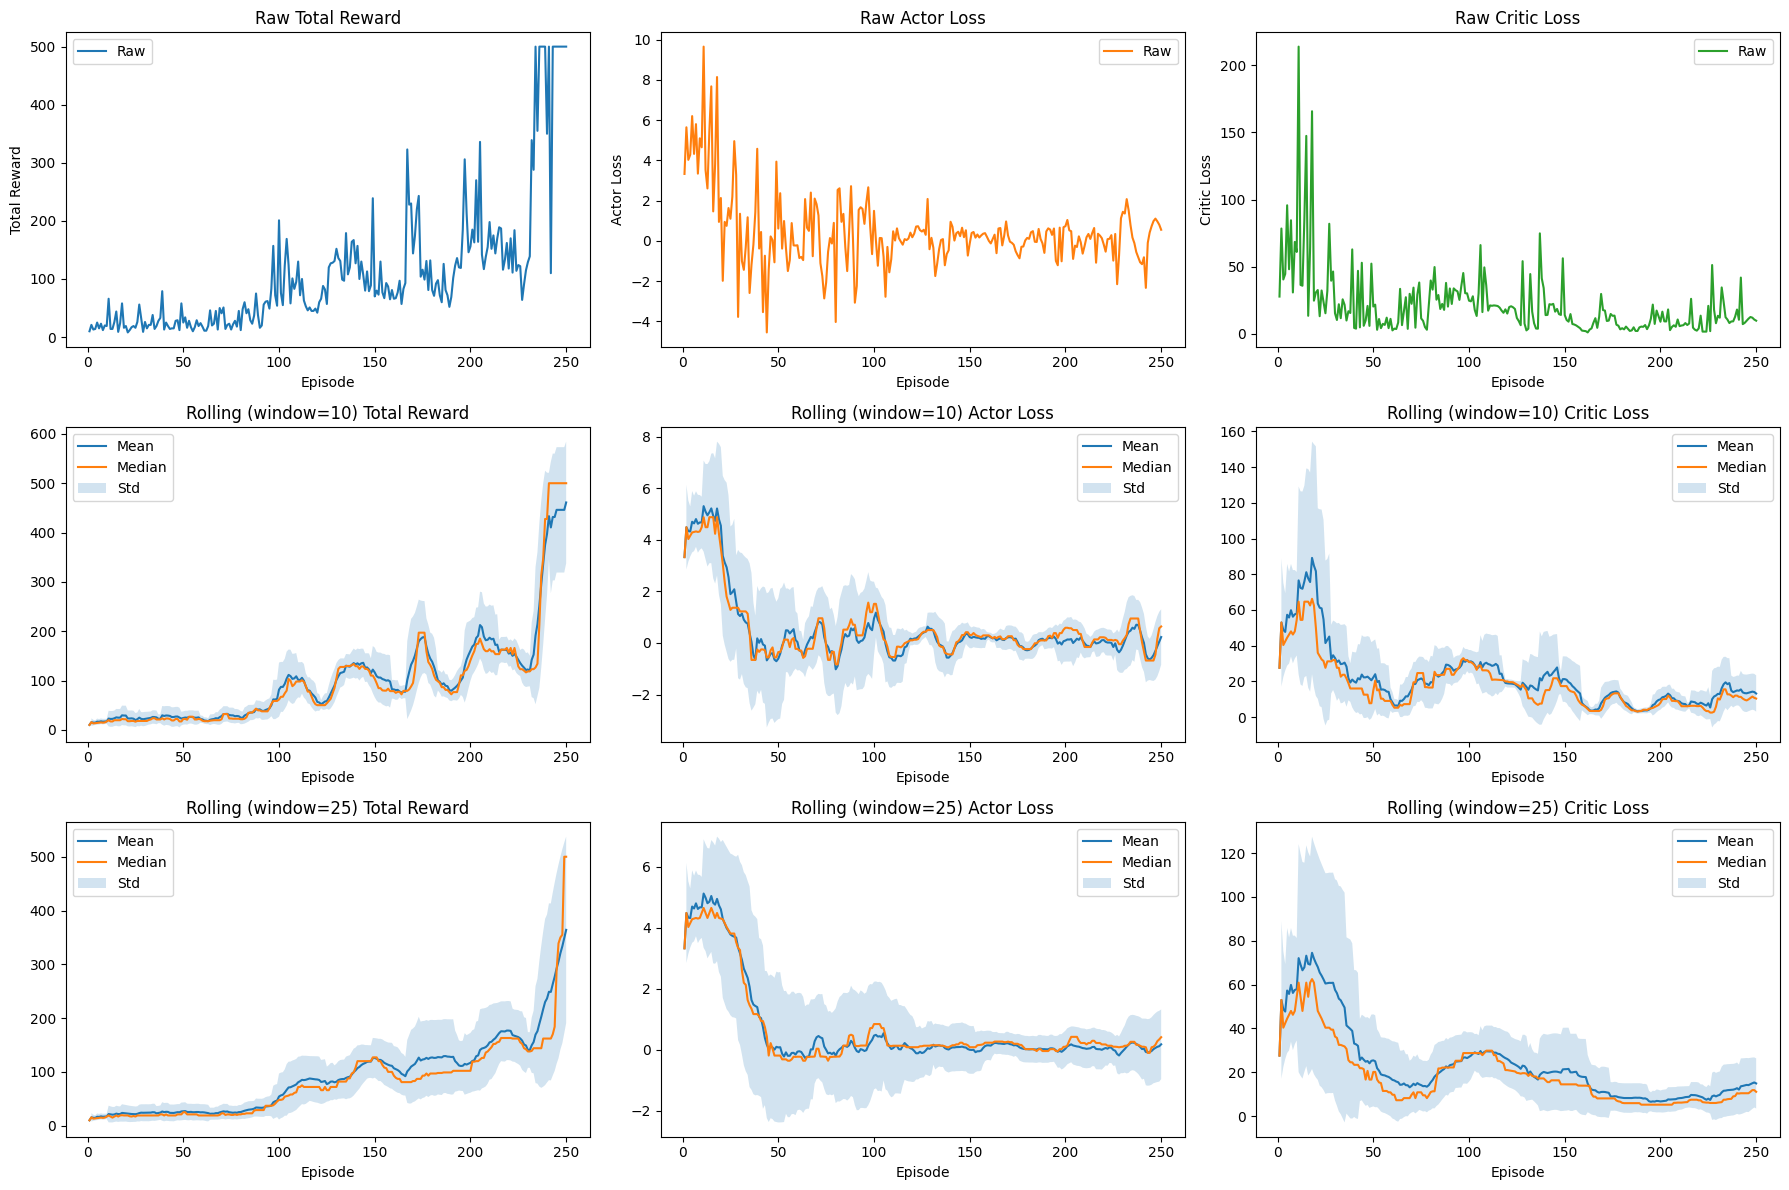

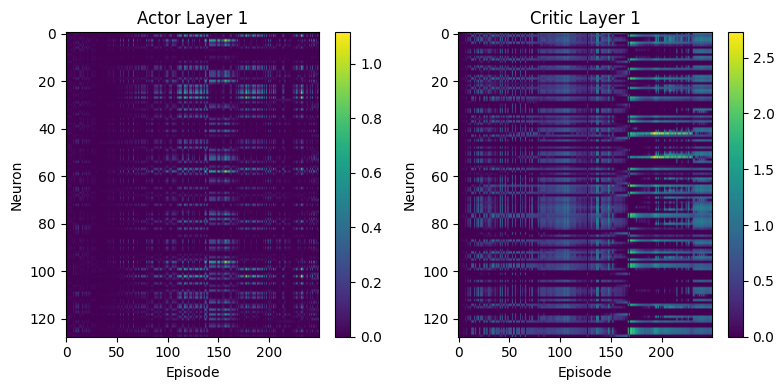

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

Episode 10	Total Reward: 20.00	Actor Loss: 4.8735	Critic Loss: 65.0153
Episode 20	Total Reward: 12.00	Actor Loss: 0.2888	Critic Loss: 23.4939
Episode 30	Total Reward: 22.00	Actor Loss: 0.1026	Critic Loss: 29.9235
Episode 40	Total Reward: 12.00	Actor Loss: 0.0501	Critic Loss: 2.2509
Episode 50	Total Reward: 13.00	Actor Loss: 0.6644	Critic Loss: 4.0430
Episode 60	Total Reward: 16.00	Actor Loss: -2.1854	Critic Loss: 20.2608
Episode 70	Total Reward: 17.00	Actor Loss: 1.7297	Critic Loss: 10.5580
Episode 80	Total Reward: 16.00	Actor Loss: -1.5320	Critic Loss: 7.3035
Episode 90	Total Reward: 14.00	Actor Loss: 0.7277	Critic Loss: 2.3882
Episode 100	Total Reward: 19.00	Actor Loss: -1.3854	Critic Loss: 13.8296
Episode 110	Total Reward: 22.00	Actor Loss: -0.1725	Critic Loss: 11.3747
Episode 120	Total Reward: 53.00	Actor Loss: 2.5112	Critic Loss: 26.2479
Episode 130	Total Reward: 60.00	Actor Loss: 2.3831	Critic Loss: 47.3524
Episode 140	Total Reward: 22.00	Actor Loss: -2.1794	Critic Loss: 23.5476


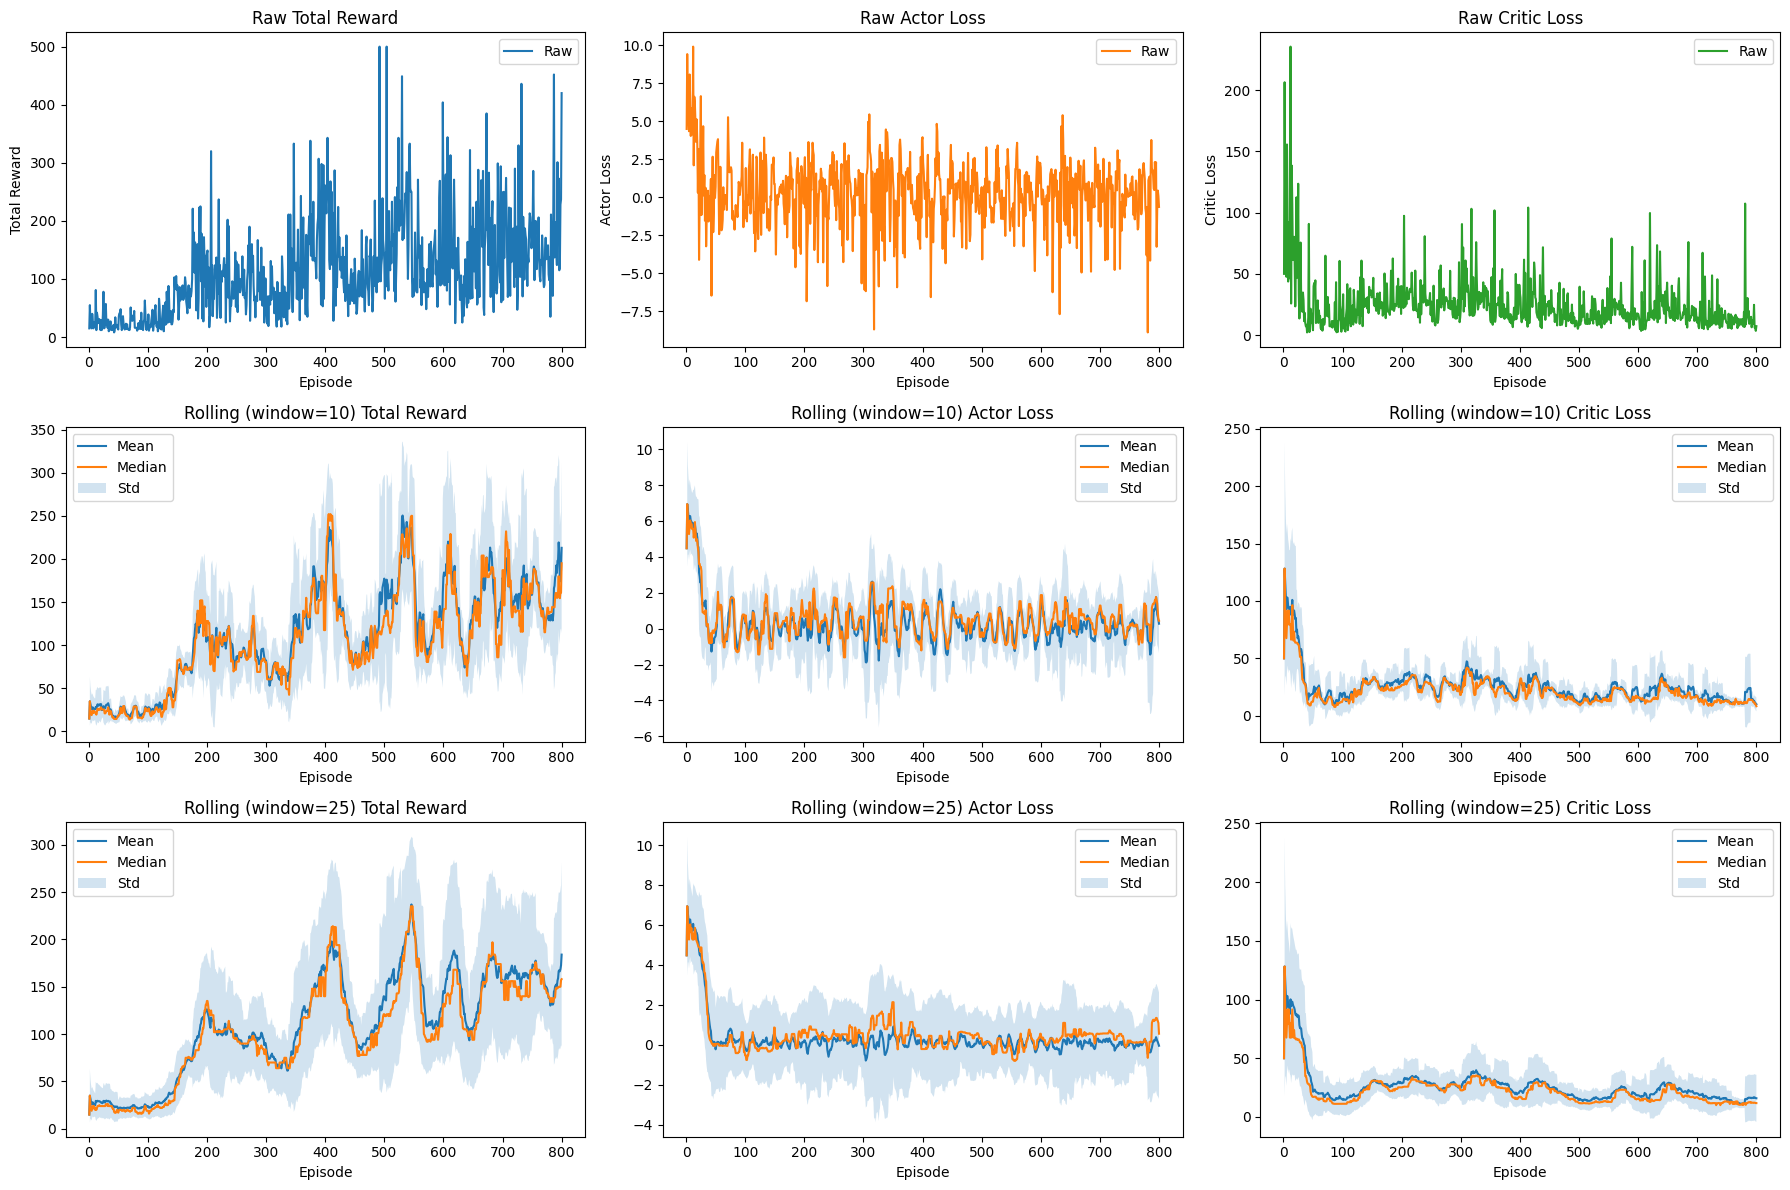

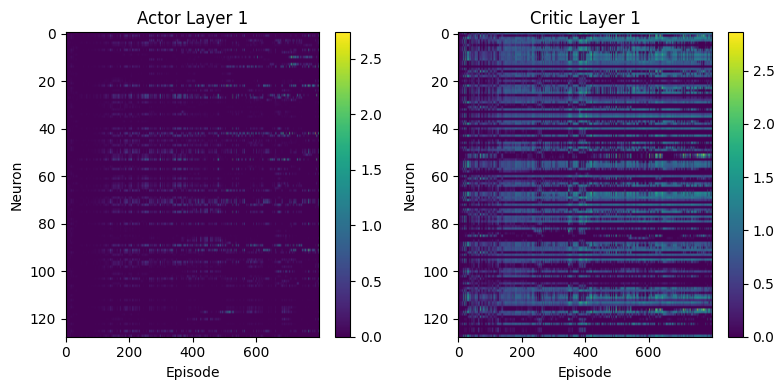

In [4]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 800,
        "gamma": 0.95,
        "noise_std": 0.2,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

---------------------------

-----------------------------------

2025-03-30 22:01:03.865718: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 17.00	Actor Loss: 4.7999	Critic Loss: 57.4865
Episode 20	Total Reward: 17.00	Actor Loss: 4.5359	Critic Loss: 54.1074
Episode 30	Total Reward: 19.00	Actor Loss: 4.6678	Critic Loss: 58.7783
Episode 40	Total Reward: 12.00	Actor Loss: 2.7850	Critic Loss: 23.5930
Episode 50	Total Reward: 13.00	Actor Loss: 2.6300	Critic Loss: 22.6040
Episode 60	Total Reward: 12.00	Actor Loss: 1.3233	Critic Loss: 13.5321
Episode 70	Total Reward: 16.00	Actor Loss: 2.0474	Critic Loss: 19.9902
Episode 80	Total Reward: 20.00	Actor Loss: 1.8986	Critic Loss: 22.7278
Episode 90	Total Reward: 26.00	Actor Loss: 2.1470	Critic Loss: 29.0070
Episode 100	Total Reward: 14.00	Actor Loss: -1.3715	Critic Loss: 16.0829
Episode 110	Total Reward: 15.00	Actor Loss: -0.7550	Critic Loss: 10.5975
Episode 120	Total Reward: 69.00	Actor Loss: 4.4505	Critic Loss: 67.6844
Episode 130	Total Reward: 48.00	Actor Loss: 2.2157	Critic Loss: 34.1710
Episode 140	Total Reward: 15.00	Actor Loss: -1.8817	Critic Loss: 13.859

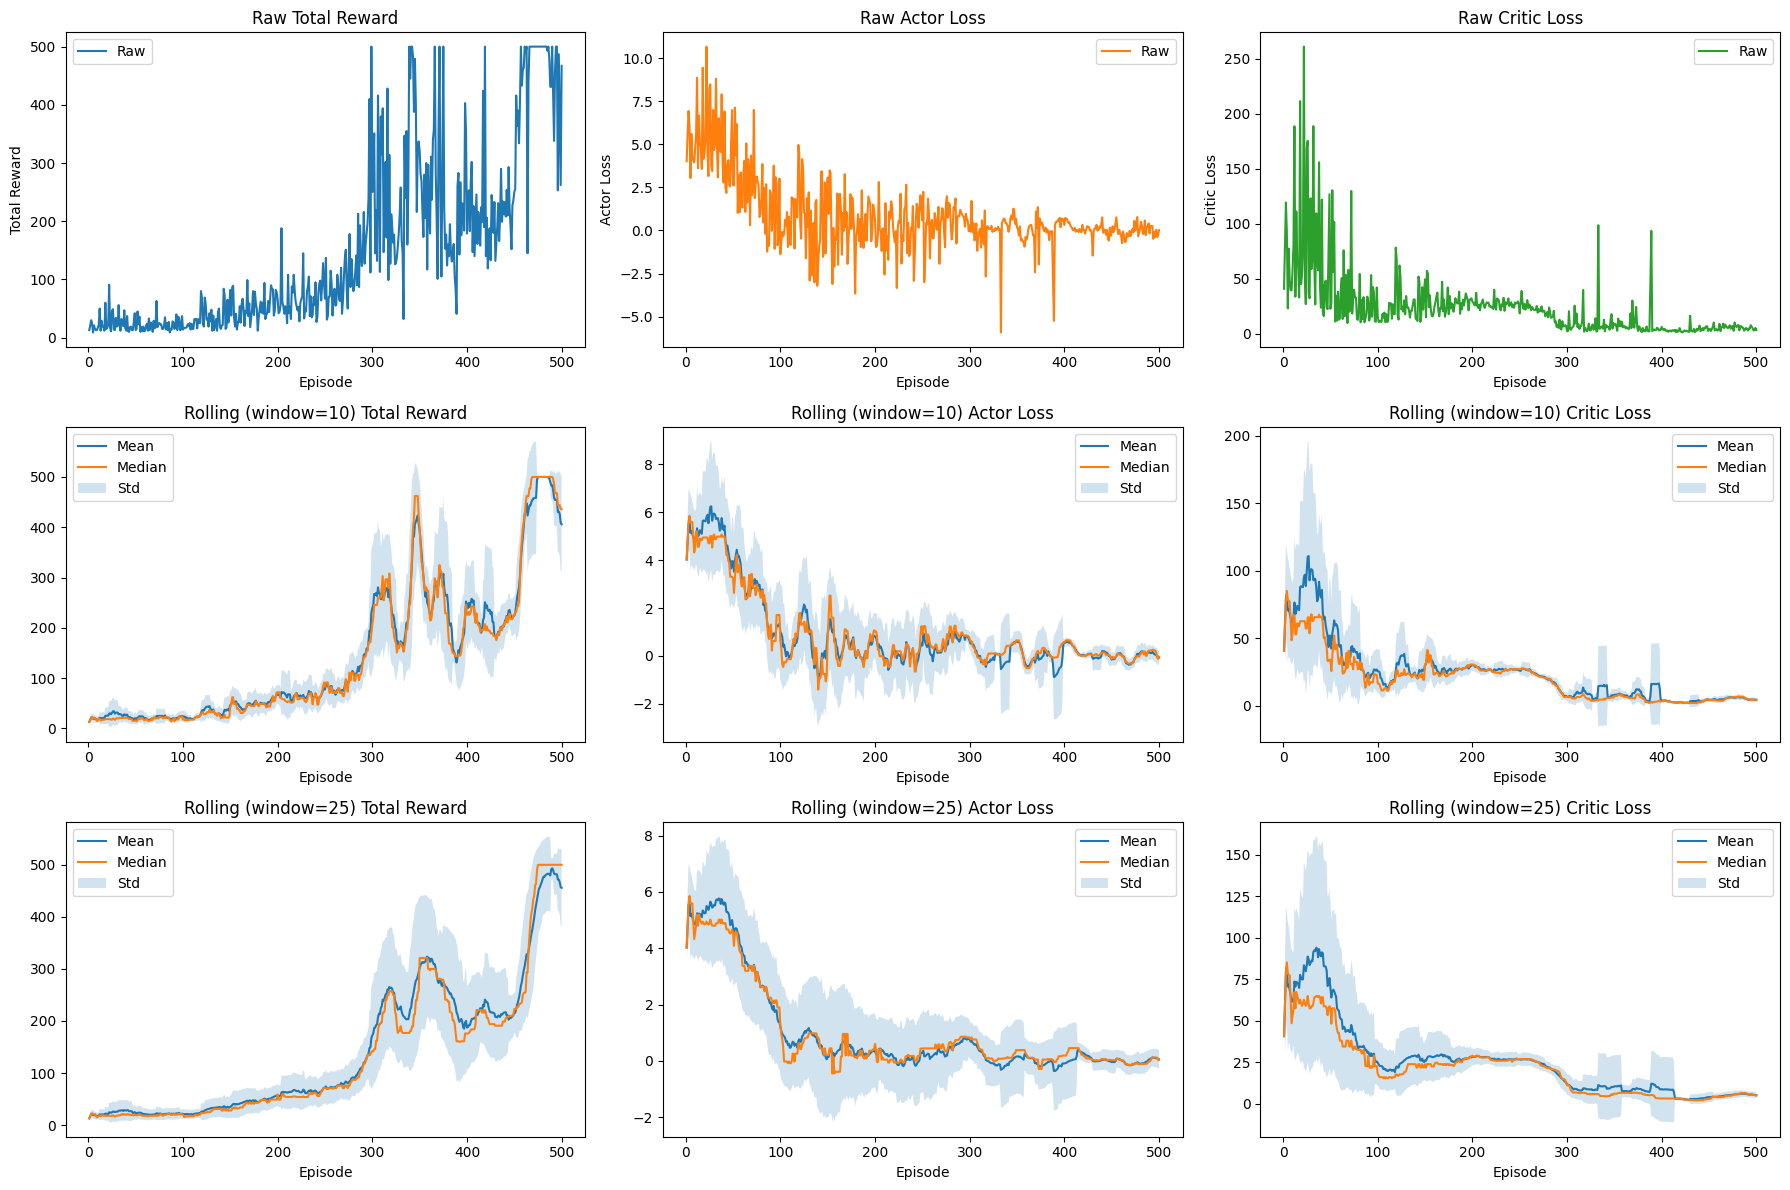

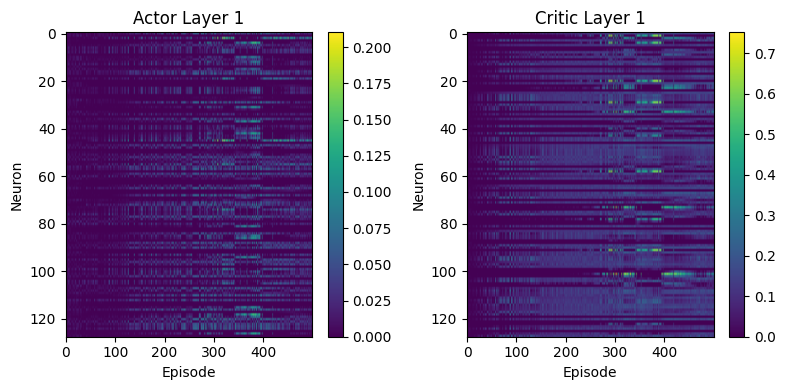

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 500,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

2025-03-30 23:47:52.873571: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 20.00	Actor Loss: 3.5203	Critic Loss: 53.3804
Episode 20	Total Reward: 12.00	Actor Loss: 0.3117	Critic Loss: 10.5991
Episode 30	Total Reward: 10.00	Actor Loss: -2.7663	Critic Loss: 23.4506
Episode 40	Total Reward: 15.00	Actor Loss: -0.4165	Critic Loss: 3.9357
Episode 50	Total Reward: 29.00	Actor Loss: 1.0484	Critic Loss: 6.2544
Episode 60	Total Reward: 16.00	Actor Loss: -5.7993	Critic Loss: 100.5278
Episode 70	Total Reward: 27.00	Actor Loss: 2.3117	Critic Loss: 26.2125
Episode 80	Total Reward: 27.00	Actor Loss: 1.2284	Critic Loss: 16.7410
Episode 90	Total Reward: 45.00	Actor Loss: 1.0766	Critic Loss: 23.1453
Episode 100	Total Reward: 36.00	Actor Loss: -2.4807	Critic Loss: 42.7746
Episode 110	Total Reward: 79.00	Actor Loss: 1.8674	Critic Loss: 39.3737
Episode 120	Total Reward: 54.00	Actor Loss: -0.2790	Critic Loss: 19.9764
Episode 130	Total Reward: 55.00	Actor Loss: -1.3906	Critic Loss: 41.6088
Episode 140	Total Reward: 51.00	Actor Loss: -0.0095	Critic Loss: 19.

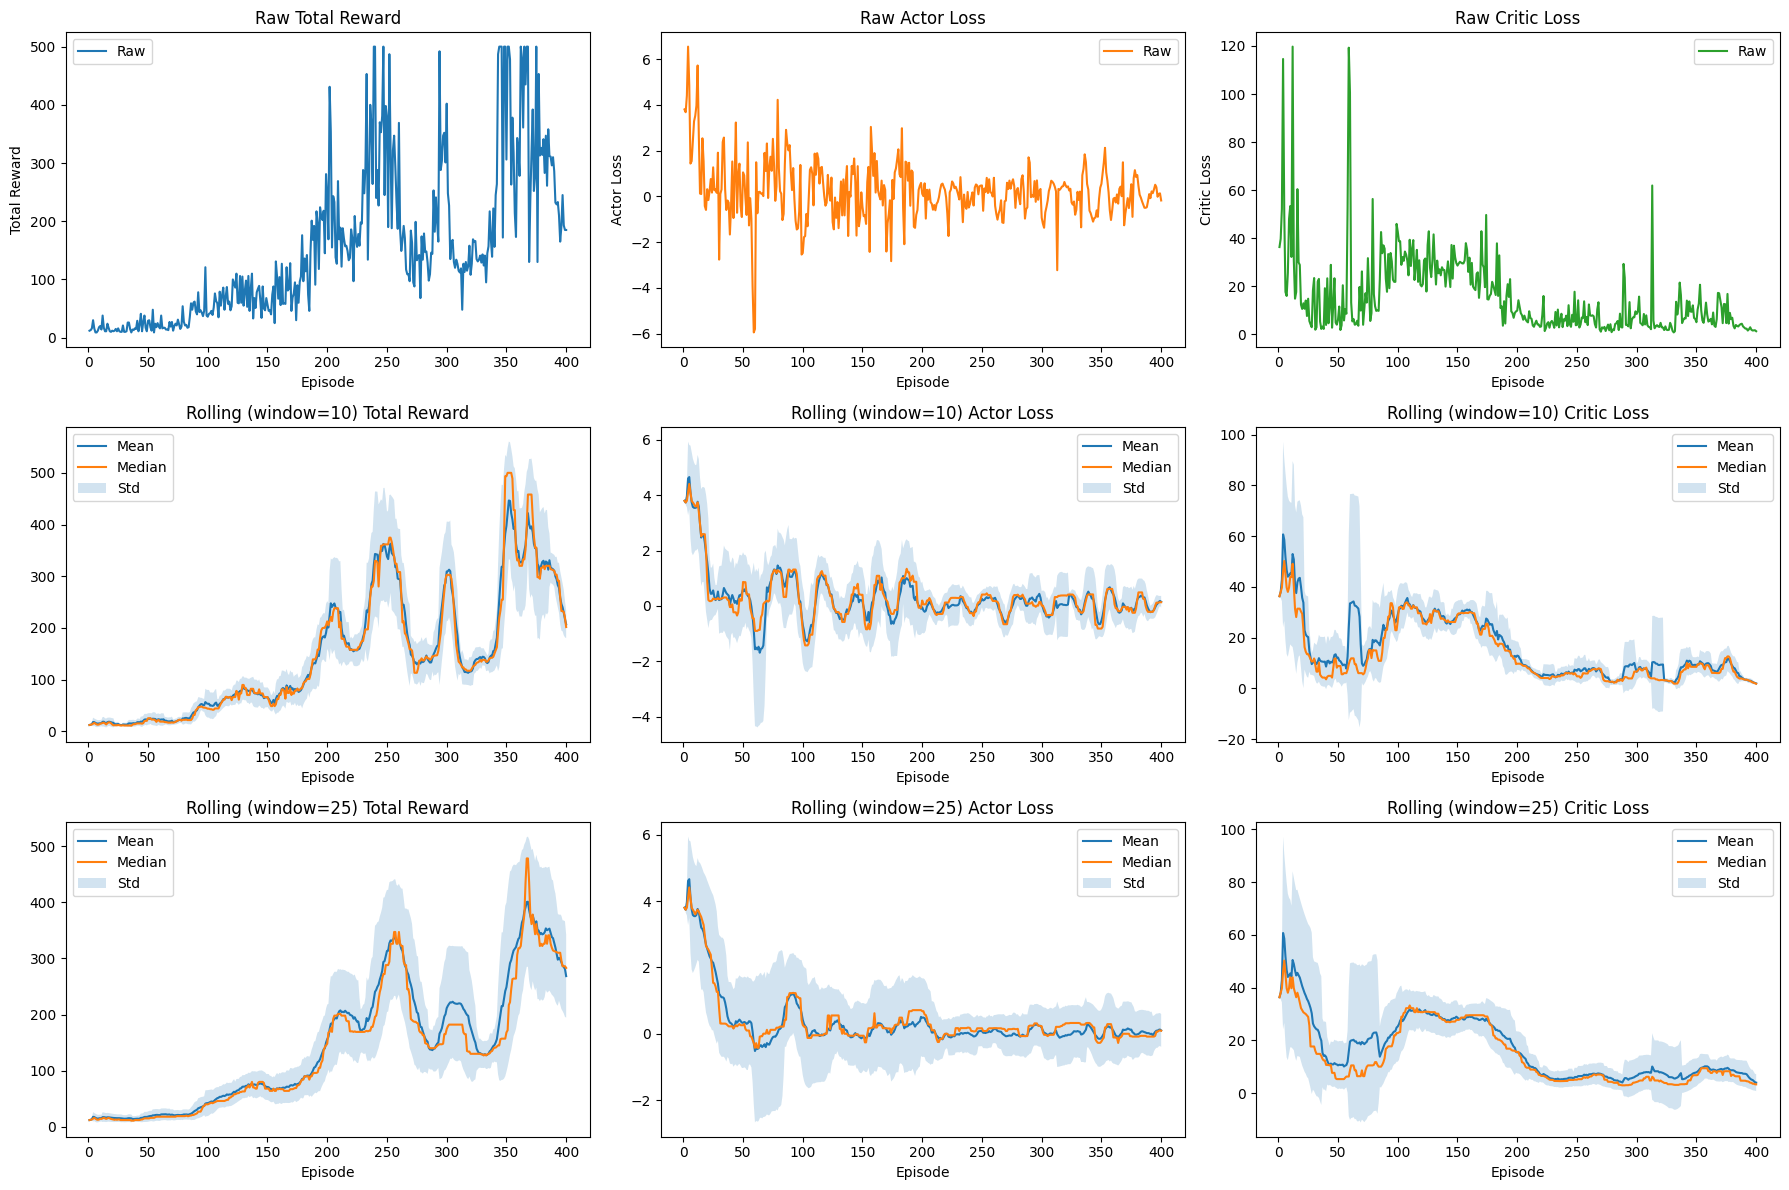

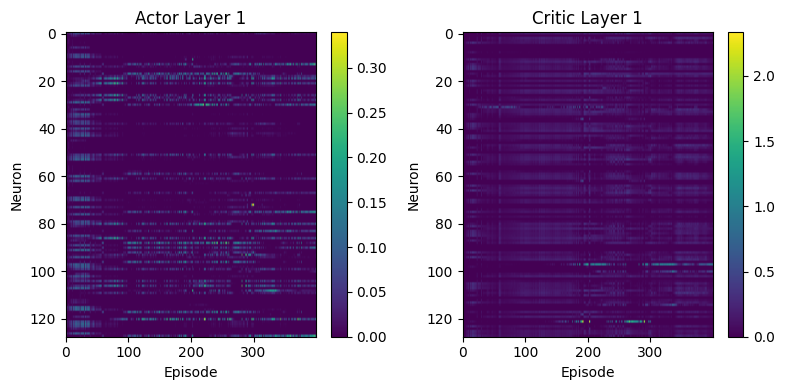

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-2,
        "critic_lr": 5e-2,
        "num_episodes": 400,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

Episode 10	Total Reward: 29.00	Actor Loss: 6.8388	Critic Loss: 115.2220
Episode 20	Total Reward: 12.00	Actor Loss: 3.7761	Critic Loss: 35.8550
Episode 30	Total Reward: 12.00	Actor Loss: 3.7710	Critic Loss: 35.7090
Episode 40	Total Reward: 27.00	Actor Loss: 6.5083	Critic Loss: 105.2890
Episode 50	Total Reward: 14.00	Actor Loss: 4.1719	Critic Loss: 44.3099
Episode 60	Total Reward: 25.00	Actor Loss: 6.1832	Critic Loss: 95.5769
Episode 70	Total Reward: 17.00	Actor Loss: 4.7562	Critic Loss: 57.7268
Episode 80	Total Reward: 13.00	Actor Loss: 3.8835	Critic Loss: 39.0327
Episode 90	Total Reward: 23.00	Actor Loss: 5.8263	Critic Loss: 85.3217
Episode 100	Total Reward: 15.00	Actor Loss: 4.2968	Critic Loss: 47.5362
Episode 110	Total Reward: 12.00	Actor Loss: 3.5722	Critic Loss: 33.5301
Episode 120	Total Reward: 14.00	Actor Loss: 4.0078	Critic Loss: 42.2096
Episode 130	Total Reward: 21.00	Actor Loss: 5.3673	Critic Loss: 74.2121
Episode 140	Total Reward: 28.00	Actor Loss: 6.5077	Critic Loss: 105.179

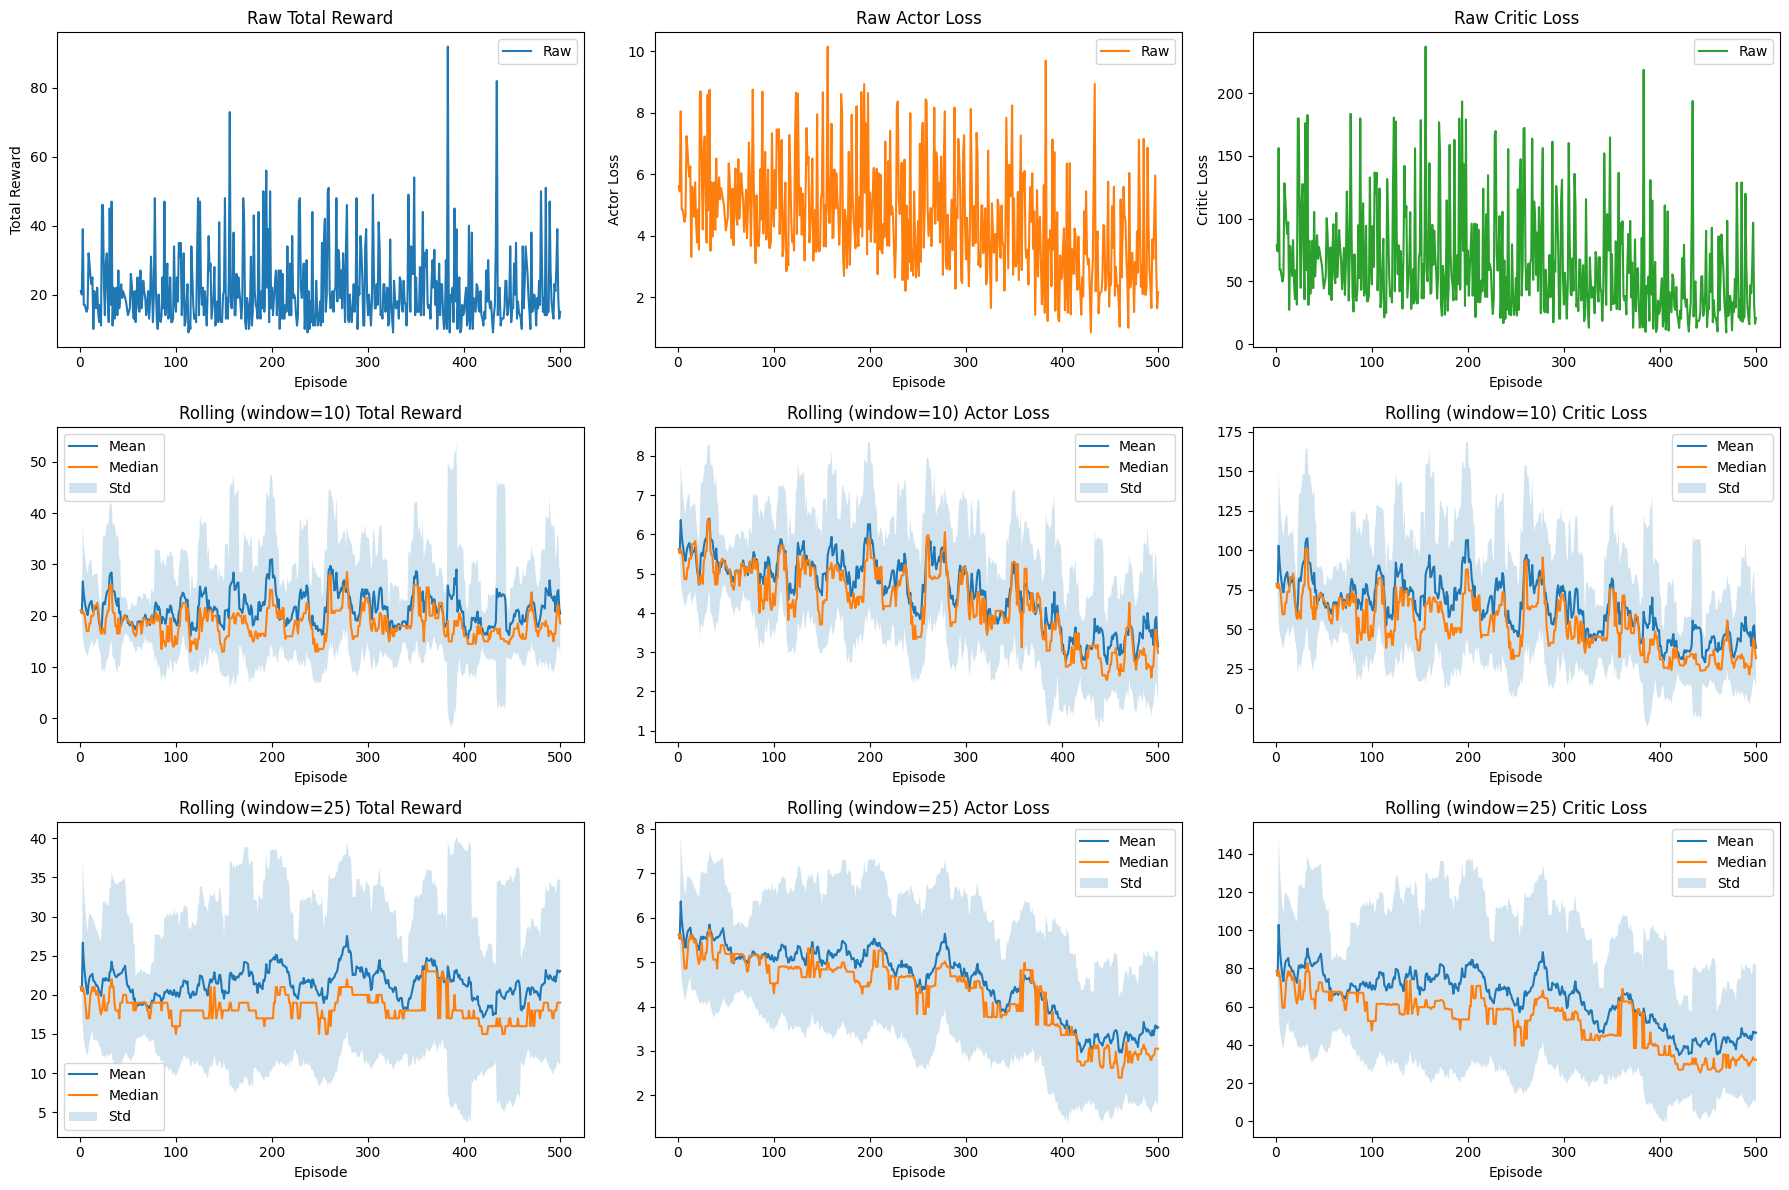

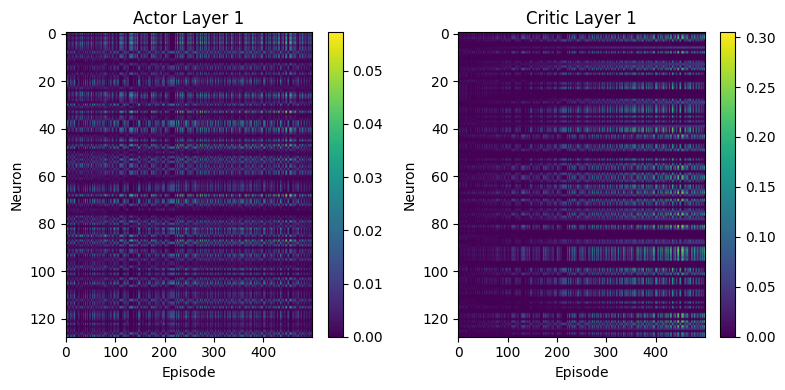

In [3]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 500,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

Episode 10	Total Reward: 12.00	Actor Loss: 3.7913	Critic Loss: 34.4857
Episode 20	Total Reward: 16.00	Actor Loss: 4.3153	Critic Loss: 50.0741
Episode 30	Total Reward: 16.00	Actor Loss: 4.1472	Critic Loss: 46.0542
Episode 40	Total Reward: 31.00	Actor Loss: 6.4062	Critic Loss: 105.8910
Episode 50	Total Reward: 19.00	Actor Loss: 4.0165	Critic Loss: 48.6073
Episode 60	Total Reward: 26.00	Actor Loss: 4.7765	Critic Loss: 67.1079
Episode 70	Total Reward: 26.00	Actor Loss: 4.0920	Critic Loss: 56.4637
Episode 80	Total Reward: 22.00	Actor Loss: 3.1219	Critic Loss: 34.0251
Episode 90	Total Reward: 16.00	Actor Loss: 0.8309	Critic Loss: 16.1953
Episode 100	Total Reward: 26.00	Actor Loss: 2.3048	Critic Loss: 30.5185
Episode 110	Total Reward: 27.00	Actor Loss: 1.8619	Critic Loss: 27.7435
Episode 120	Total Reward: 49.00	Actor Loss: 3.9591	Critic Loss: 59.3946
Episode 130	Total Reward: 50.00	Actor Loss: 3.5747	Critic Loss: 51.0371
Episode 140	Total Reward: 27.00	Actor Loss: 0.7390	Critic Loss: 18.3443


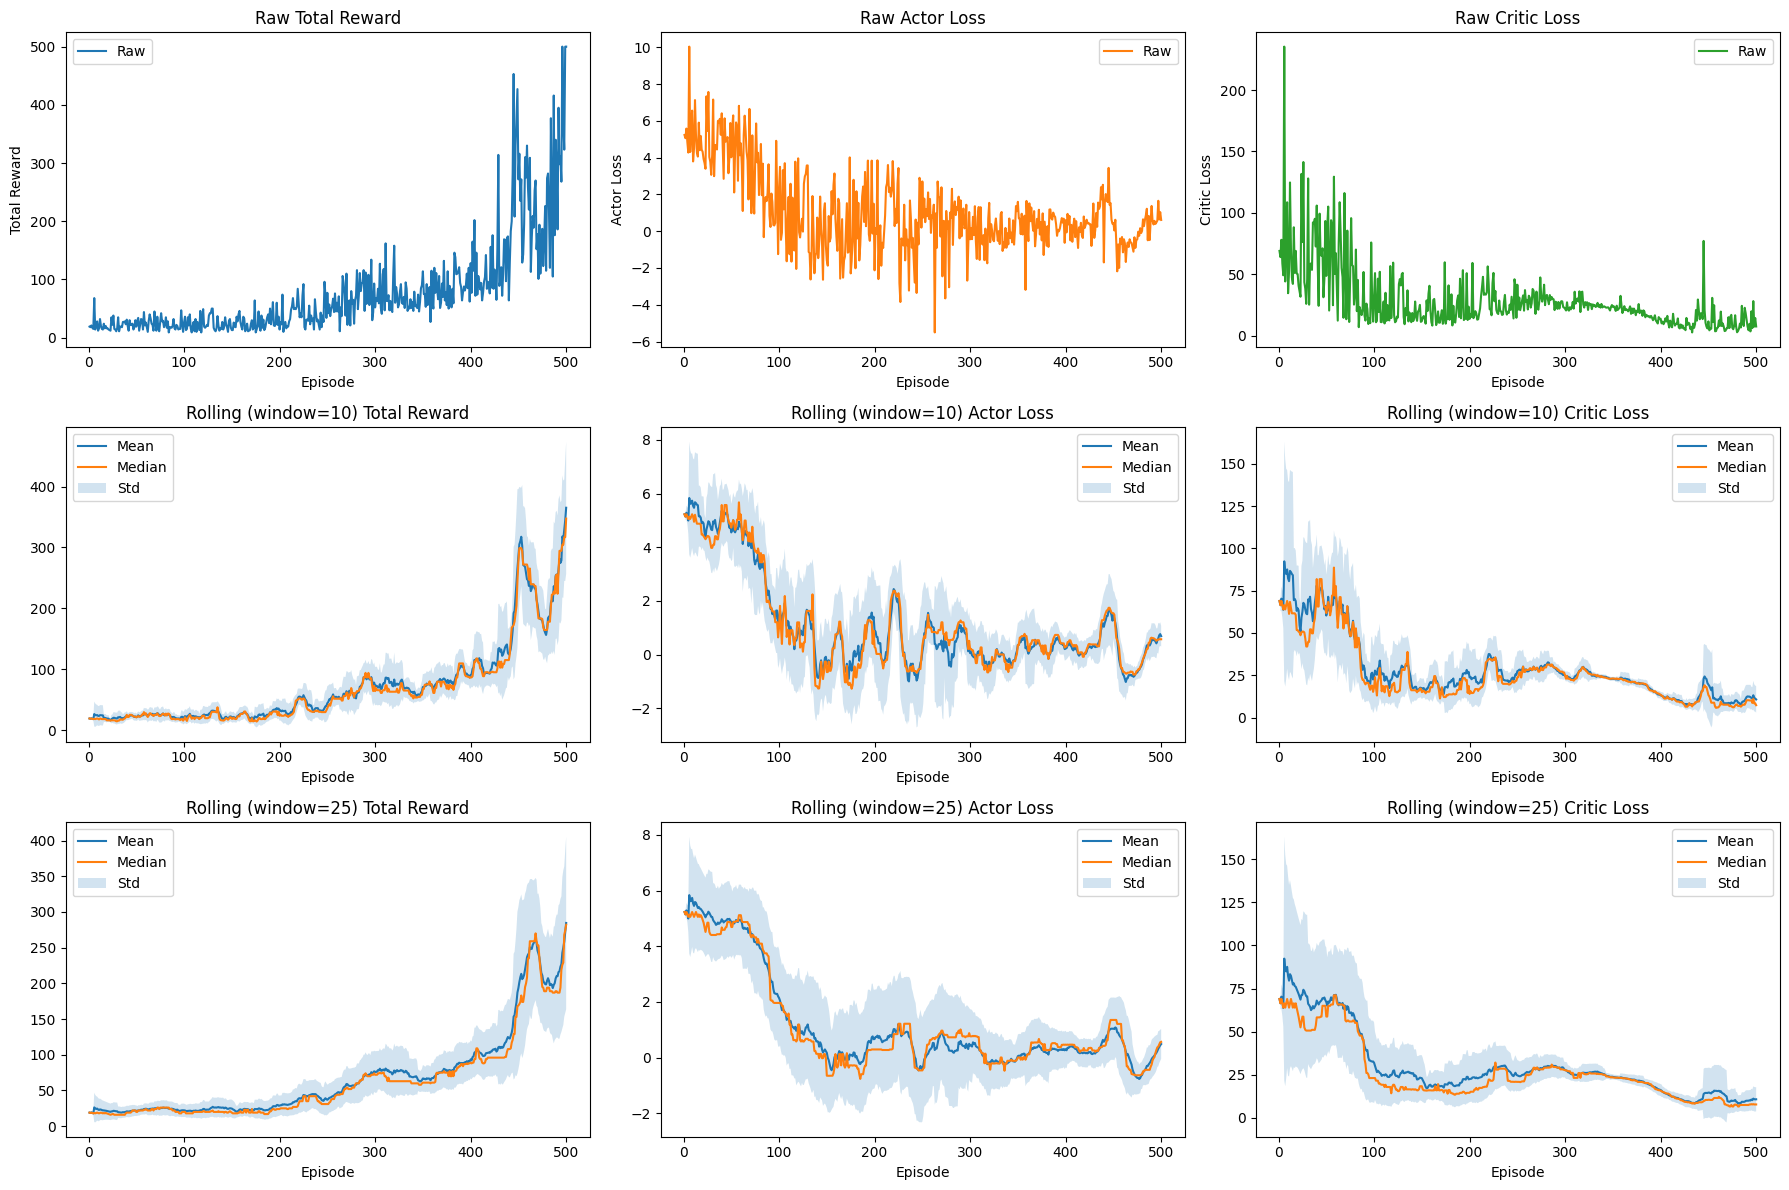

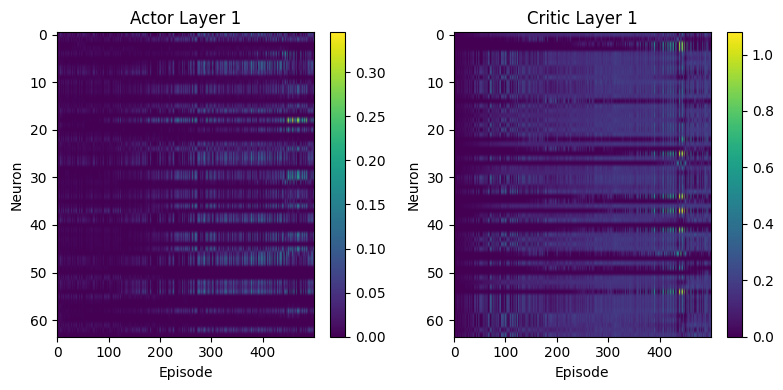

In [4]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 64,
        "critic_hidden_size": 64,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 500,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 500,
        "gamma": 0.99,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

2025-03-31 10:34:20.713805: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 11.00	Actor Loss: 3.9934	Critic Loss: 40.7121
Episode 20	Total Reward: 27.00	Actor Loss: 8.7703	Critic Loss: 204.0175
Episode 30	Total Reward: 18.00	Actor Loss: 5.8676	Critic Loss: 93.6567
Episode 40	Total Reward: 29.00	Actor Loss: 8.4678	Critic Loss: 210.4687
Episode 50	Total Reward: 21.00	Actor Loss: 6.1767	Critic Loss: 108.0662
Episode 60	Total Reward: 17.00	Actor Loss: 3.1185	Critic Loss: 52.0068
Episode 70	Total Reward: 13.00	Actor Loss: 0.6404	Critic Loss: 27.0333
Episode 80	Total Reward: 10.00	Actor Loss: 0.2849	Critic Loss: 10.5115
Episode 90	Total Reward: 29.00	Actor Loss: 4.7634	Critic Loss: 106.9142
Episode 100	Total Reward: 35.00	Actor Loss: 5.8219	Critic Loss: 146.1951
Episode 110	Total Reward: 23.00	Actor Loss: 1.1259	Critic Loss: 40.0182
Episode 120	Total Reward: 26.00	Actor Loss: 0.5076	Critic Loss: 51.9446
Episode 130	Total Reward: 41.00	Actor Loss: 3.4101	Critic Loss: 119.7192
Episode 140	Total Reward: 41.00	Actor Loss: 1.9054	Critic Loss: 99.

2025-03-31 11:48:11.955727: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 28.00	Actor Loss: 2.7204	Critic Loss: 46.6749
Episode 20	Total Reward: 13.00	Actor Loss: -2.5725	Critic Loss: 21.9378
Episode 30	Total Reward: 90.00	Actor Loss: 3.6542	Critic Loss: 65.0390
Episode 40	Total Reward: 101.00	Actor Loss: 0.5783	Critic Loss: 12.2203
Episode 50	Total Reward: 56.00	Actor Loss: -2.9986	Critic Loss: 76.2465
Episode 60	Total Reward: 43.00	Actor Loss: -0.2439	Critic Loss: 15.0477
Episode 70	Total Reward: 48.00	Actor Loss: 0.1603	Critic Loss: 15.8334
Episode 80	Total Reward: 153.00	Actor Loss: 0.9093	Critic Loss: 31.2463
Episode 90	Total Reward: 88.00	Actor Loss: 0.1376	Critic Loss: 32.0801
Episode 100	Total Reward: 41.00	Actor Loss: -1.0402	Critic Loss: 15.9932
Episode 110	Total Reward: 65.00	Actor Loss: 0.7181	Critic Loss: 10.7098
Episode 120	Total Reward: 136.00	Actor Loss: 0.3551	Critic Loss: 5.1092
Episode 130	Total Reward: 252.00	Actor Loss: 1.2731	Critic Loss: 36.1268
Episode 140	Total Reward: 269.00	Actor Loss: -0.0857	Critic Loss: 

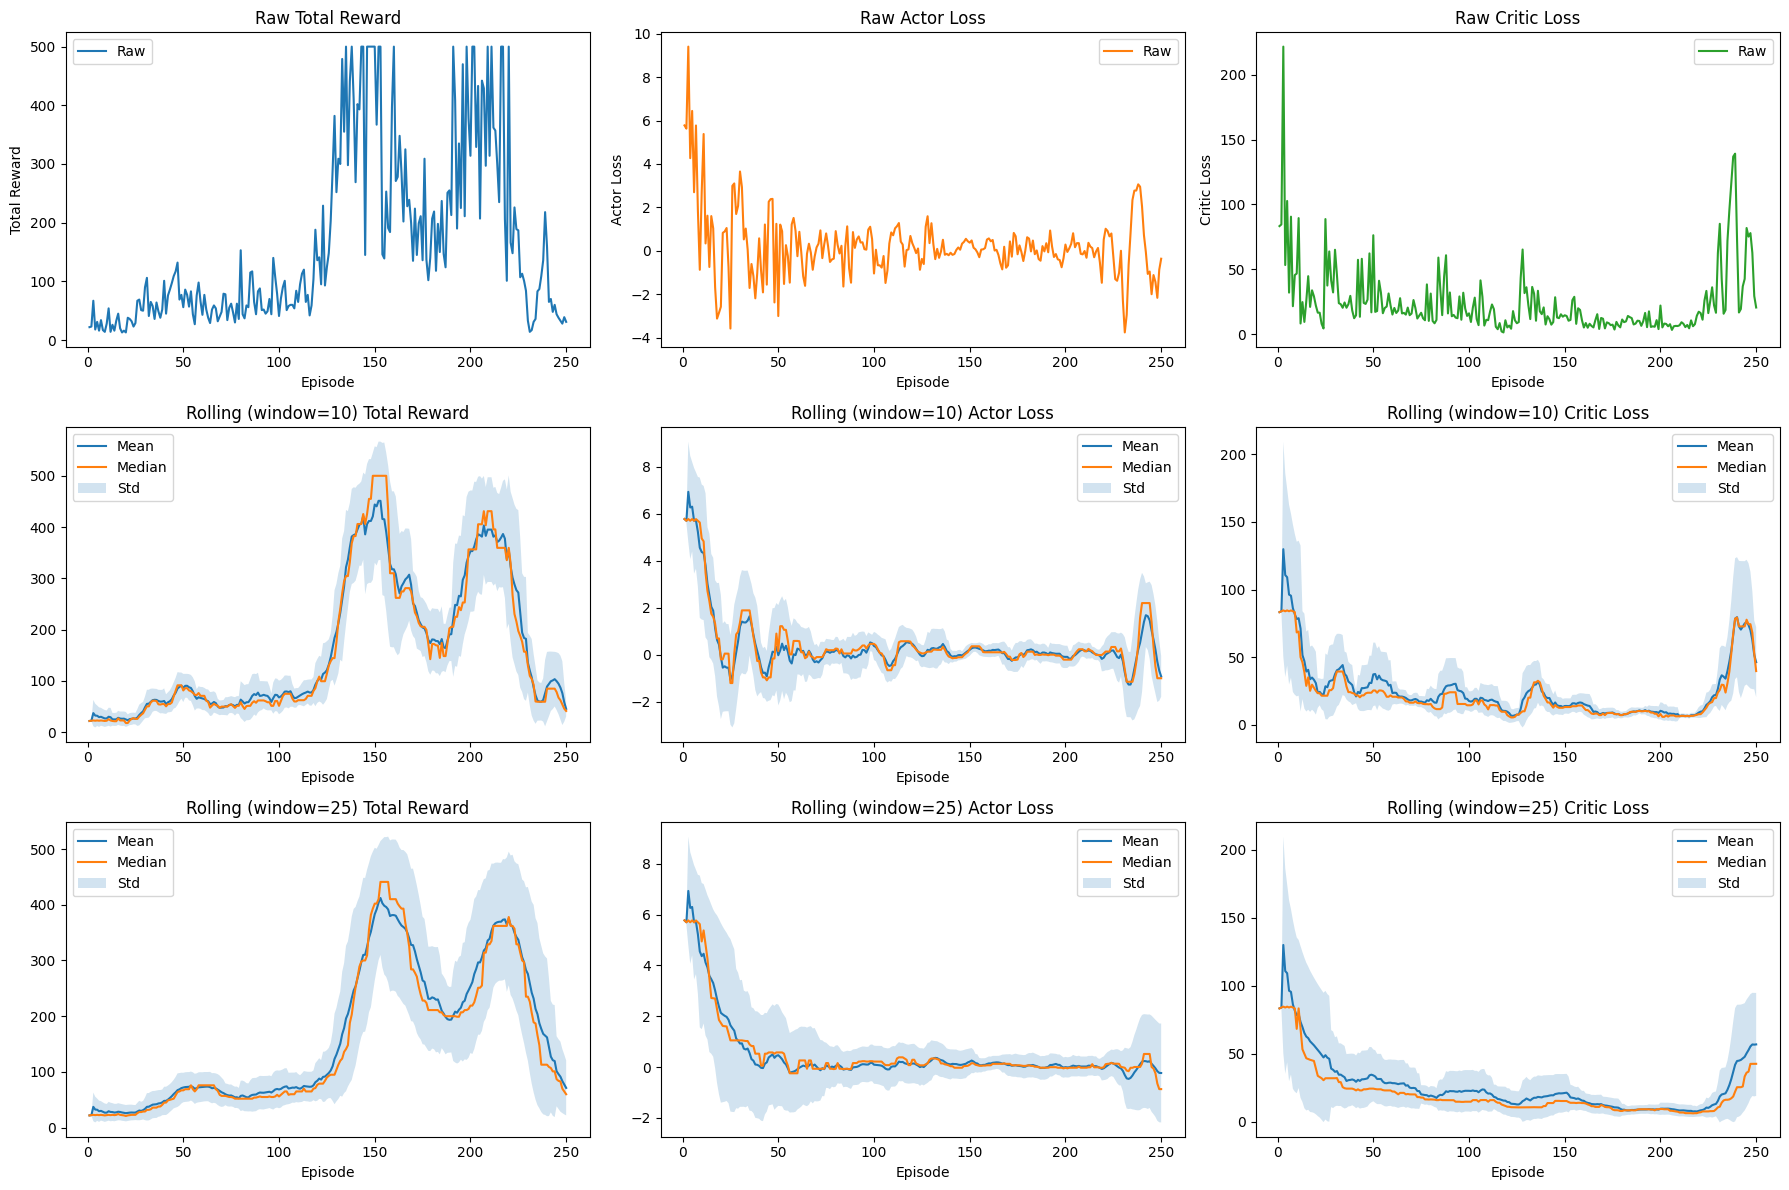

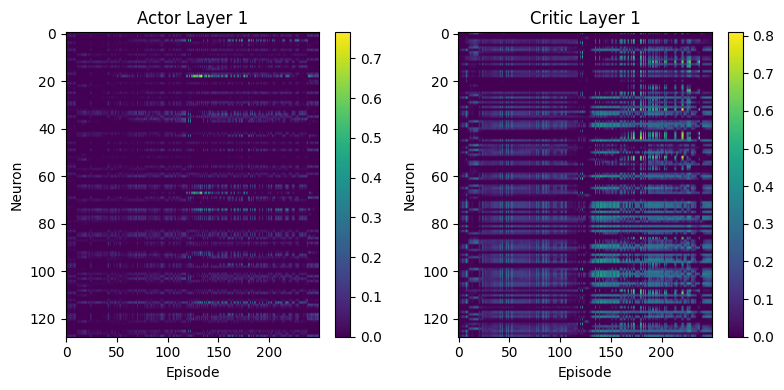

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-1,
        "critic_lr": 1e-1,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-2,
        "critic_lr": 5e-2,
        "num_episodes": 400,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        "gru_type": "modified"
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        gru_type=config["gru_type"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)
plot_firing_rates(actor_firing_rates, critic_firing_rates)

2025-03-31 13:31:52.553129: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 31.00	Actor Loss: 6.0973	Critic Loss: 98.8523
Episode 20	Total Reward: 24.00	Actor Loss: 2.3574	Critic Loss: 27.1768
Episode 30	Total Reward: 17.00	Actor Loss: -1.3298	Critic Loss: 22.2404
Episode 40	Total Reward: 44.00	Actor Loss: 3.3491	Critic Loss: 47.4991
Episode 50	Total Reward: 25.00	Actor Loss: -0.0703	Critic Loss: 15.9183
Episode 60	Total Reward: 18.00	Actor Loss: -2.2048	Critic Loss: 27.4088
Episode 70	Total Reward: 17.00	Actor Loss: -1.5427	Critic Loss: 13.3121
Episode 80	Total Reward: 50.00	Actor Loss: 3.1958	Critic Loss: 36.9495
Episode 90	Total Reward: 23.00	Actor Loss: -0.9033	Critic Loss: 13.9492
Episode 100	Total Reward: 62.00	Actor Loss: 0.9625	Critic Loss: 28.9948
Episode 110	Total Reward: 28.00	Actor Loss: -2.0677	Critic Loss: 18.0719
Episode 120	Total Reward: 57.00	Actor Loss: 0.7532	Critic Loss: 14.7456
Episode 130	Total Reward: 65.00	Actor Loss: 0.4758	Critic Loss: 16.0265
Episode 140	Total Reward: 162.00	Actor Loss: 2.3654	Critic Loss: 33